In [10]:
import os; os.chdir('/Users/sqian/MKTSRV')
from math import log10, floor
from matplotlib import pyplot as plt
from random import sample
from src.calculation.LegacyUnusualPriceVolumeMovement import UnusualPriceVolumeMovement
from src.data_models.SmartsCsvDataModel import SmartsCsvDataModel
from src.data_models.SmartsDataModel import SmartsDataModel
from src.data_models.smartshelper import metrics, fixNum, unSMART, cparty, littleQA, totalUP
from src.utility.DataModelUtility import execute_query_data_frame
from xlsxwriter.utility import xl_rowcol_to_cell
import datetime
import math
import matplotlib as mpl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment',None)
import re
import xlrd

def perc(arg,df): print(str(int(arg*100)) + 'th Percentile: ' + str(int(round(df.quantile(arg)))))

#### Step 0: Symbols and their cooresponding ingestion month-years

In [2]:
symbol_list = ['BTCUSD', 'ETHBTC', 'ETHUSD', 'ZECBTC', 'ZECETH', 'ZECUSD', 'LTCBTC', 'LTCETH', 'LTCUSD', 'ZECLTC']
symbol_listBCH = ['BCHBTC', 'BCHETH', 'BCHUSD', 'LTCBCH', 'ZECBCH']

#### Step 1: Read smarts csv data from datalab

In [3]:
eval_date = datetime.date(2019, 1, 31)
begin_date = datetime.date(2018, 11, 1)
begin_date2 = datetime.date(2018, 12, 11)

instruments = symbol_list
instruments2 = symbol_listBCH

In [4]:
data_model = SmartsCsvDataModel(download_data=True).evaluate(instrument=instruments, evaluation_date=eval_date, begin_date=begin_date, use_db=False)
data_model.keys()

INFO:root:Constructing Singleton
INFO:root:Using global configuration /Users/sqian/msv.yaml.
INFO:root:Completed loading configuration.


download_smarts_data 0:00:00.059160
read_csv_to_dk_dataframe 0:00:16.000003
pre_cleaning 0:14:01.481539
pre_cleaning 0:04:08.252830
pre_cleaning 0:11:06.683208
pre_cleaning 0:02:30.326327
pre_cleaning 0:04:09.336107
pre_cleaning 0:04:50.431938
pre_cleaning 0:01:25.461313
pre_cleaning 0:01:53.815316
pre_cleaning 0:02:20.672876
pre_cleaning 0:00:14.903644


dict_keys(['BTCUSD', 'ETHBTC', 'ETHUSD', 'ZECBTC', 'ZECETH', 'ZECUSD', 'LTCBTC', 'LTCETH', 'LTCUSD', 'ZECLTC'])

In [5]:
data_model_BCH = SmartsCsvDataModel(download_data=True).evaluate(instrument=instruments2, evaluation_date=eval_date, begin_date=begin_date2, use_db=False)
data_model_BCH.keys()

download_smarts_data 0:00:00.011409
read_csv_to_dk_dataframe 0:00:02.772959
pre_cleaning 0:00:28.962752
pre_cleaning 0:00:11.476145
pre_cleaning 0:01:01.269863
pre_cleaning 0:00:00.692816
pre_cleaning 0:00:00.790636


dict_keys(['BCHBTC', 'BCHETH', 'BCHUSD', 'LTCBCH', 'ZECBCH'])

#### Step 2: Rollup

In [22]:
datafull = pd.DataFrame()

for i in data_model.keys():
    datatemp = data_model[i][['symbol','fill_price']].set_index('symbol').dropna().pct_change()
    datafull = pd.concat([datafull,datatemp], axis=0)
    
for i in data_model_BCH.keys():
    datatemp = data_model_BCH[i][['symbol','fill_price']].set_index('symbol').dropna().pct_change()
    datafull = pd.concat([datafull,datatemp], axis=0)

In [26]:
datafull0trunc = datafull.loc[datafull['fill_price'] != 0] 
data = pd.concat([datafull.groupby('symbol').count(),datafull0trunc.groupby('symbol').count()], axis=1)
data.columns=['count','count_0truc']
data

,count,count_0truc
symbol,,
BCHBTC,1639,441
BCHETH,627,133
BCHUSD,27462,7100
BTCUSD,1194393,344899
ETHBTC,84517,13050
ETHUSD,654911,168213
LTCBCH,141,40
LTCBTC,10365,1987
LTCETH,34325,8525


In [47]:
datafull_gb = datafull.groupby('symbol')['fill_price']
dataquantiles = pd.concat([datafull_gb.count(),datafull_gb.quantile(0.99),datafull_gb.quantile(0.995),datafull_gb.quantile(0.999)], axis=1)
dataquantiles.columns = ['count','99th_%ile','99.5th_%ile','99.9th_%ile']
quant = dataquantiles.sort_values('count', ascending=False)

In [53]:
datafull_gb_T = datafull['fill_price']
dataquantiles_T = pd.DataFrame([datafull_gb_T.count(),datafull_gb_T.quantile(0.99),datafull_gb_T.quantile(0.995),datafull_gb_T.quantile(0.999)]).transpose()
dataquantiles_T.columns = ['count','99th_%ile','99.5th_%ile','99.9th_%ile']
quant_T = dataquantiles_T.sort_values('count', ascending=False)

In [54]:
pd.concat([quant,quant_T], axis=0)

,count,99th_%ile,99.5th_%ile,99.9th_%ile
BTCUSD,1194393.0,0.001377,0.001843,0.003202
ETHUSD,654911.0,0.002168,0.002983,0.005743
ETHBTC,84517.0,0.003070,0.004805,0.011152
ZECUSD,78875.0,0.008831,0.012494,0.022499
LTCUSD,61878.0,0.009154,0.012748,0.022826
LTCETH,34325.0,0.003520,0.005327,0.014773
BCHUSD,27462.0,0.015131,0.022341,0.041512
LTCBTC,10365.0,0.012501,0.018912,0.034723
ZECBTC,8929.0,0.013748,0.018681,0.035340
ZECETH,4569.0,0.025962,0.035030,0.070476


#### Step 3: Quantiles

outliers: (309, 1)
99th: 12.0
99.5th: 23.997184281571844
99.9th: 78.79065467913361


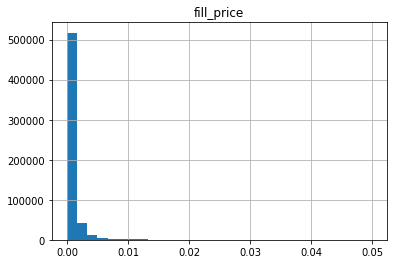

In [56]:
print('outliers:', datafull.shape)
print('99th:', round(datafull.quantile(0.99)[0]))
print('99.5th:', datazerotrunc_outlier.quantile(0.995)[0])
print('99.9th:', datafull.quantile(0.999)[0])
print('99.975th:', datazerotrunc_outlier.quantile(0.99975)[0])

datazerotrunc_clipped.hist(bins=30)
plt.show()

In [ ]:
break

#### Step 4: Calculations

In [ ]:
percentile = 0.99975
estimatepermo = round(totaldict.shape[0]*(1-percentile)/(eval_date-begin_date).days*30)

print(totaldict.shape[0],' total',sep='')
print('percentile =',percentile)
print('E[trans/mo] =',estimatepermo)

print('\n',metrics(totaldict['symbol']))

In [ ]:
totaldict.dtypes

In [ ]:
temp = totaldict['abs_price_pct_change_over_5m']
print('5 min price change distribution 2017-2019')
print('99th percentile:',round(temp.quantile(0.99),2))
print('99.9th percentile:',round(temp.quantile(0.999),2))
print('99.975th percentile:',round(temp.quantile(0.99975),2))
temp.clip(0,temp.quantile(0.99)).hist(bins=30); plt.show()

# temp = totaldict['abs_price_pct_change_over_10m']
# print('10 min price change distribution 2017-2019')
# print('99th percentile:',round(temp.quantile(0.99),2))
# print('99.9th percentile:',round(temp.quantile(0.999),2))
# print('99.975th percentile:',round(temp.quantile(0.99975),2))
# temp.clip(0,temp.quantile(0.99)).hist(bins=30); plt.show()

# temp = totaldict['abs_price_pct_change_over_60m']
# print('60 min price change distribution 2017-2019')
# print('99th percentile:',round(temp.quantile(0.99),2))
# print('99.9th percentile:',round(temp.quantile(0.999),2))
# print('99.975th percentile:',round(temp.quantile(0.99975),2))
# temp.clip(0,temp.quantile(0.99)).hist(bins=30); plt.show()

#### Step 5: UPM_1001 Settings

In [ ]:
metricsPrice = ['abs_price_pct_change_over_5m', 'abs_price_pct_change_over_10m', 'abs_price_pct_change_over_60m']

alice_1001 = pd.DataFrame(totaldict.quantile(percentile)[metricsPrice]*100).rename(columns={percentile:'percentile9995'})
alice_1001['AliceCode'] = '(' + round(alice_1001['percentile9995'],0).astype(str) + '%,$9999999),(0.1%,)'

print(alice_1001['AliceCode'])

#### Step 6: UVM_2011 Setting

In [ ]:
metricsQuantity = ['quantity_sum_past_5m', 'quantity_sum_past_10m', 'quantity_sum_past_60m']
changedict = {'quantity_sum_past_5m':'quant5m', 'quantity_sum_past_10m':'quant10m', 'quantity_sum_past_60m':'quant60m'}

alice_2011 = round(totaldict.groupby('symbol').quantile(percentile)[metricsQuantity]).astype(int).rename(columns=changedict).reset_index(drop=False)
alice_2011['AliceCode_5m'] = '{' + alice_2011['symbol'] + ',(x' + round(alice_2011['quant5m'],3).astype(str) + ',)};'
alice_2011['AliceCode_10m'] = '{' + alice_2011['symbol'] + ',(x' + round(alice_2011['quant10m'],3).astype(str) + ',)};'
alice_2011['AliceCode_60m'] = '{' + alice_2011['symbol'] + ',(x' + round(alice_2011['quant60m'],3).astype(str) + ',)};'

print('(x999999,);',''.join(alice_2011['AliceCode_5m'].tolist()),sep='')
print('(x999999,);',''.join(alice_2011['AliceCode_10m'].tolist()),sep='')
print('(x999999,);',''.join(alice_2011['AliceCode_60m'].tolist()),sep='')

In [ ]:
symbol_list = ['BTCUSD', 'ETHBTC', 'ETHUSD', 'ZECBTC', 'ZECETH', 'ZECUSD']
symbol_listLTC = ['LTCBTC', 'LTCETH', 'LTCUSD', 'ZECLTC']
symbol_listBCH = ['BCHBTC', 'BCHETH', 'BCHUSD', 'LTCBCH', 'ZECBCH']

In [ ]:
inst = symbol_list + symbol_listLTC + symbol_listBCH

In [ ]:
for i in inst:  
    print(i)
#     print(alice_2011.loc[alice_2011['symbol'] == i,'quant5m'])
#     alice_2011['quant10m'].hist(bins=30); plt.show()
#     alice_2011['quant60m'].hist(bins=30); plt.show()


In [ ]:
alice_2011